# Interpolation by factorized matrix completion

We try to solve the following problem:

$$
arg \;  min_\mathbf{X} \frac{1}{2}||\mathbf{y}-\mathbf{RX}||_2^2 + \mu ||\mathbf{X}||_* = \frac{1}{2}||\mathbf{y}-\mathbf{R\mathbf{U}\mathbf{V}^T}||_2^2 + \mu ||\mathbf{U}\mathbf{V}^T||_*
$$

We use two relaxed versions:

- Regularization with factorized nuclear norm ($||\mathbf{U}\mathbf{V}^T||_*=||\mathbf{U}||_F^2+ ||\mathbf{V}||_F^2$):
$$
arg \;  min_\mathbf{X} \frac{1}{2}||\mathbf{y}-\mathbf{R}(\mathbf{U}\mathbf{V}^T)||_2^2 + \mu ||\mathbf{U}||_F^2+ \mu ||\mathbf{V}||_F^2
$$

- Constrained with factorized nuclear norm ($||\mathbf{U}\mathbf{V}^T||_* \le \frac{1}{2} ||\mathbf{U}, \mathbf{V}||_F^2$):
$$
arg \;  min_\mathbf{X} \frac{1}{2}||\mathbf{y}-\mathbf{R}(\mathbf{U}\mathbf{V}^T)||_2^2 s.t \frac{1}{2} ||\mathbf{U}, \mathbf{V}||_F^2
$$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy import misc
from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr

from pylops import LinearOperator
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *
from pylops.utils.backend import get_array_module, to_cupy_conditional

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.utils.bilinear import LowRankFactorizedMatrix

In [2]:
# Restriction operator
n, m, k = 200, 100, 10
sub = 0.4
nsub = int(n*m*sub)
iava = np.random.permutation(np.arange(n*m))[:nsub]

Rop = Restriction(n*m, iava)

In [3]:
# model
U = np.random.normal(0., 1., (n, k))
V = np.random.normal(0., 1., (m, k))

X = U @ V.T

# data
y = Rop * X.ravel()

# Masked data
Y = (Rop.H * Rop * X.ravel()).reshape(n, m)

Let's use our function to perform:

- $\mathbf{y}=\mathbf{R}\mathbf{U}\mathbf{V}^T = R_v(\mathbf{u})$
- $\mathbf{y}=\mathbf{R}\mathbf{U}\mathbf{V}^T = R_u(\mathbf{v})$

In [4]:
LOp = LowRankFactorizedMatrix(U, V.T, y, Op=Rop)

y-LOp._matvecx(U.ravel()), y-LOp._matvecy(V.T.ravel())

(array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))

## Soft constraint
Let's consider the following functional composed of a sum of a smooth term f(x) and a non-smooth one g(x)

$$
arg \;  min_\mathbf{X} f(x)+g(x)
$$

we define the overall model vector $x = [u, v]$, $f=\frac{1}{2}||\mathbf{y}-\mathbf{R}(\mathbf{U}\mathbf{V}^T)||_2^2$  and $g= \mu ||\mathbf{U}||_F^2+ \mu ||\mathbf{V}||_F^2$ (which is the sum of partial elements of x so the proximal is just the vertical stack of their proximals.

Now we can write our iteration as:

$$
x^{k+1} = prox_{\mu\tau^kg} (x^{k} - \tau^k \nabla f)
$$

where $\nabla f = [\nabla f_u, \nabla f_v] = [R_v^T(R_v u^k -y), R_u^T(R_u v^k -y)]$ and the proximal of the Frobenious norm ($prox_g$) is as simple as that of the L2 squared norm of the vector x.

In [5]:
n, m, k = 100, 90, 10
X = np.random.normal(0, 1, (n, k))
Y = np.random.normal(0, 1, (k, m))
X = sp.ndimage.gaussian_filter(X, 1)
Y = sp.ndimage.gaussian_filter(Y, 1)
A = X @ Y

sub = 0.01
nsub = int(n*m*sub)
print(nsub)
iava = np.random.permutation(np.arange(n*m))[:nsub]
Rop = Restriction(n*m, iava)

hop = LowRankFactorizedMatrix(X.copy(), Y.copy(), Rop @ A.ravel(), Rop)

hop.grad(np.hstack([X.ravel(), Y.ravel()]))

90


array([0., 0., 0., ..., 0., 0., 0.])

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.utils.bilinear.LowRankFactorizedMatrix'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
tau = 0.005	beta=5.000000e-01
epsg = 1.0	niter = 500	niterback = 100

   Itn       x[0]          f           g       J=f+eps*g
     1  -8.12075e-01   3.921e+03   2.976e+01   3.950e+03
     2  -7.09176e-01   2.490e+03   2.444e+01   2.515e+03
     3  -6.44772e-01   1.890e+03   2.169e+01   1.912e+03
     4  -5.98184e-01   1.574e+03   2.006e+01   1.594e+03
     5  -5.61551e-01   1.386e+03   1.900e+01   1.405e+03
     6  -5.30958e-01   1.262e+03   1.828e+01   1.280e+03
     7  -5.04152e-01   1.173e+03   1.777e+01   1.191e+03
     8  -4.79721e-01   1.104e+03   1.742e+01   1.122e+03
     9  -4.56731e-01   1.046e+03   1.717e+01   1.064e+03
    10  -4.34547e-01   9.945e+02   1.700e+01   1.012e+03
    51  -8.67737e-02   9.857e+01   1.944e+01   1.180e+02
   101  

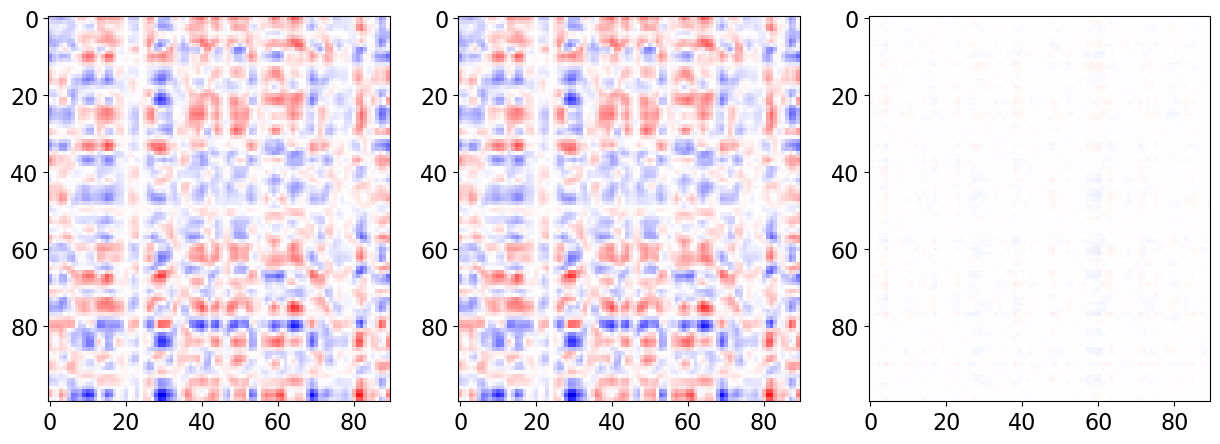

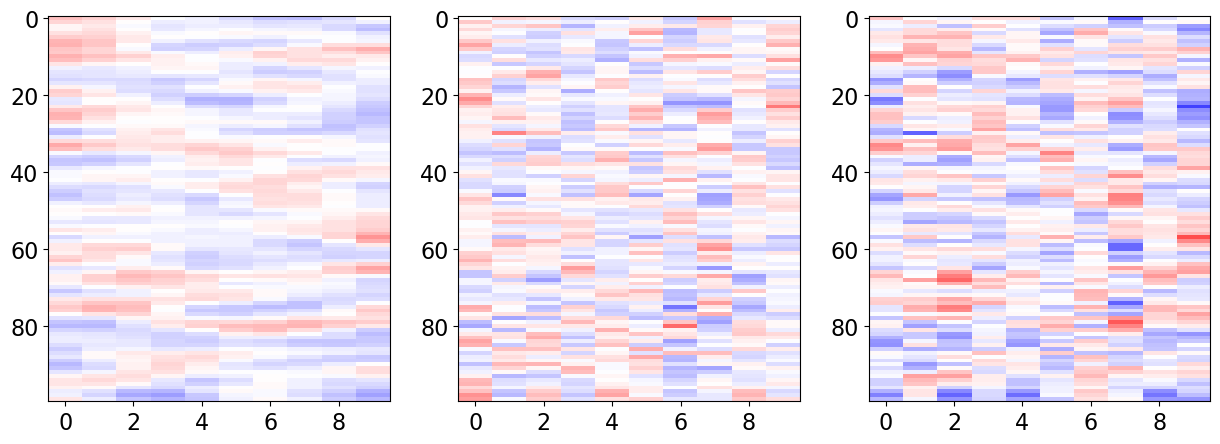

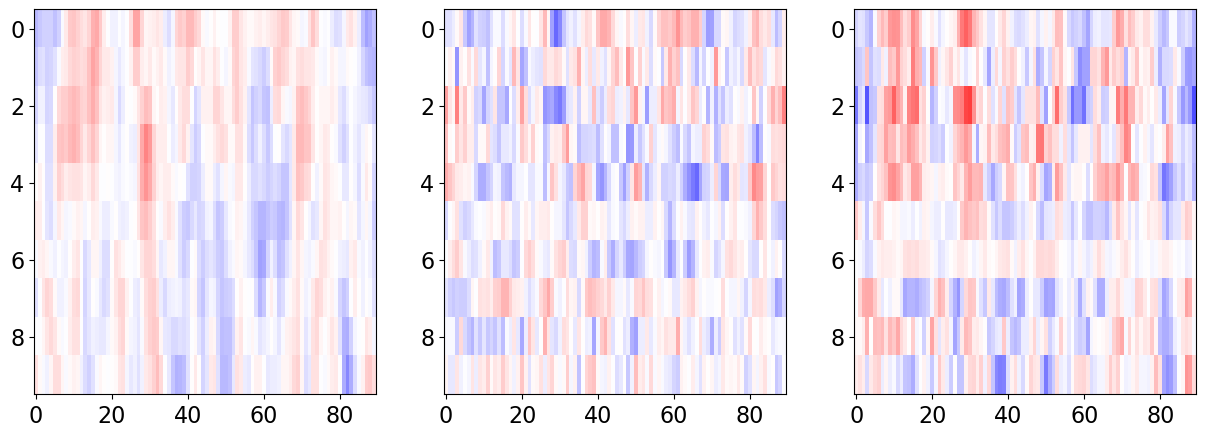

In [6]:
# easy, close to X and Y
#Xin = np.random.normal(0, 0.2, (n, k)) + X
#Yin = np.random.normal(0, 0.2, (k, m)) + Y

# hard, random
Xin = np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m))

sigma = 0.1
hop = LowRankFactorizedMatrix(Xin.copy(), Yin.copy(), A.ravel())
l2 = VStack((L2(sigma=sigma), L2(sigma=sigma)), nn=(n*k, n*k))

xest = ProximalGradient(hop, l2, x0=np.hstack([Xin.ravel(), Yin.ravel()]), 
                        tau=5e-3, niter=500, show=True)

Xest, Yest = xest[:n*k].reshape(n, k), xest[n*k:].reshape(k, m)
Aest = Xest @ Yest

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(A, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Aest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(A-Aest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(X, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Xest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(X-Xest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Y, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Yest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(Y-Yest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

## Hard constraint

Let's consider the following functional composed of a sum of a smooth term f(x) and a non-smooth one g(x)

$$
arg \;  min_x f(x) s.t. g(x)<\sigma
$$

we define the overall model vector $x = [u, v]$, $f=\frac{1}{2}||\mathbf{y}-\mathbf{R}(\mathbf{U}\mathbf{V}^T)||_2^2$  and $g= ||\mathbf{U}\mathbf{V}^T||_* \le \frac{1}{2} ||\mathbf{U}, \mathbf{V}||_F^2 = \Phi(\mathbf{U}, \mathbf{V})$ 

Here the proximal is obtained by multipluing each matrix by $\sqrt{\frac{\tau}{\Phi(\mathbf{U}, \mathbf{V})}}$

In [7]:
from pyproximal.ProxOperator import _check_tau
from pyproximal import ProxOperator

class FrobeniousFactorized(ProxOperator):

    def __init__(self, n, m, k, sigma):
        super().__init__(None, False)
        self.n, self.m, self.k = n, m, k
        self.sigma = sigma
        
    def __call__(self, x):
        L, R = x[:self.n*self.k].reshape(self.n, self.k), x[self.n*self.k:].reshape(self.k, self.m)
        return 0.5 * np.linalg.norm(np.vstack([L, R.T]), ord='fro') ** 2

    @_check_tau
    def prox(self, x, tau):
        L, R = x[:self.n*self.k].reshape(self.n, self.k), x[self.n*self.k:].reshape(self.k, self.m)
        scale = np.sqrt(self.sigma / self(x))
        L, R = scale * L, scale * R
        x = np.hstack([L.ravel(), R.ravel()])
        return x

In [8]:
# easy, close to X and Y
#Xin = np.random.normal(0, 0.2, (n, k)) + X
#Yin = np.random.normal(0, 0.2, (k, m)) + Y

# hard, random
Xin = np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m))

fb = FrobeniousFactorized(n, m, k, sigma=5.)

xx = np.hstack([Xin.ravel(), Yin.ravel()])
print(fb(xx))
yy = fb.prox(xx, 1.) # tau is irrelevant
print(fb(yy))

905.5690156592345
5.000000000000001


Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.utils.bilinear.LowRankFactorizedMatrix'>
Proximal operator (g): <class '__main__.FrobeniousFactorized'>
tau = 0.005	beta=5.000000e-01
epsg = 1.0	niter = 500	niterback = 100

   Itn       x[0]          f           g       J=f+eps*g
     1   4.49002e-02   1.325e+03   9.703e+01   1.423e+03
     2   5.84334e-02   1.275e+03   9.703e+01   1.372e+03
     3   7.41936e-02   1.222e+03   9.703e+01   1.319e+03
     4   9.19738e-02   1.168e+03   9.703e+01   1.265e+03
     5   1.11517e-01   1.111e+03   9.703e+01   1.208e+03
     6   1.32510e-01   1.052e+03   9.703e+01   1.149e+03
     7   1.54587e-01   9.908e+02   9.703e+01   1.088e+03
     8   1.77336e-01   9.289e+02   9.703e+01   1.026e+03
     9   2.00317e-01   8.665e+02   9.703e+01   9.636e+02
    10   2.23086e-01   8.046e+02   9.703e+01   9.016e+02
    51   4.70077e-01   5.601e+01   9.703e+01   1.530e+02
   101   4.5

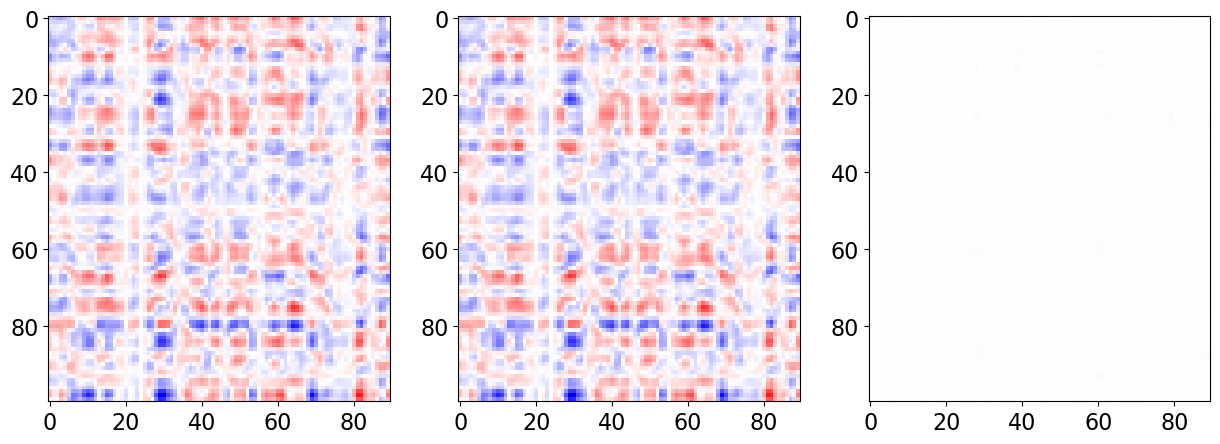

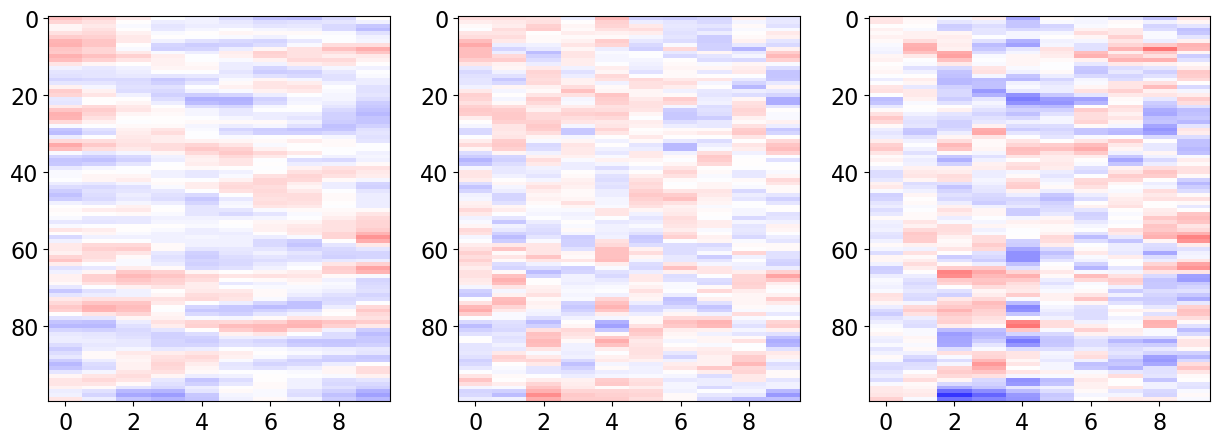

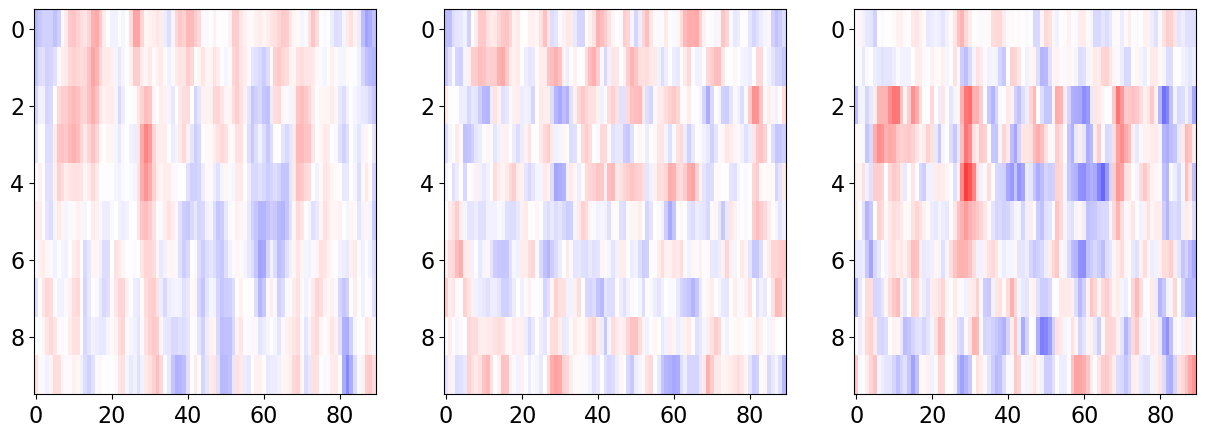

In [9]:
# easy, close to X and Y
#Xin = np.random.normal(0, 0.2, (n, k)) + X
#Yin = np.random.normal(0, 0.2, (k, m)) + Y

# hard, random
Xin = np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m))

hop = LowRankFactorizedMatrix(Xin.copy(), Yin.copy(), A.ravel())
fb = FrobeniousFactorized(n, m, k, sigma=fb(np.hstack([X.ravel(), Y.ravel()])))

xest = ProximalGradient(hop, fb, x0=np.hstack([Xin.ravel(), Yin.ravel()]), 
                        tau=5e-3, niter=500, show=True)

Xest, Yest = xest[:n*k].reshape(n, k), xest[n*k:].reshape(k, m)
Aest = Xest @ Yest

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(A, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Aest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(A-Aest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(X, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Xest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(X-Xest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Y, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Yest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(Y-Yest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');